In [1]:
#from pyprocessmacro import Process
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
import numpy as np

#dir = "C:/Users/foresight_User/Desktop/公司文件/4.CIT季賽/測試資料/"
# data = pd.read_csv(dir+"CH_TO.csv").drop(columns=["Context Name"])
# data.columns = list(map(lambda x: "x_" +str(x) ,range(len(data.columns)-1)))+["Y"]
#feature = pd.read_csv(dir+"wb/Indicator_Data(1).csv").drop(columns=["Unnamed: 74","Context Name"])#.to_numpy()
#target = pd.read_csv(dir+"wb/Metrology_Data(1).csv")[["Point1"]]#.to_numpy()


data = pd.read_csv("C:/Users/foresight_User/Data/測試資料/VISERA_170.csv").drop(columns=["Context Name","Process Start Time","Metrology Start Time"])


feature = data.drop(columns=['Point1', 'Point2', 'Point3', 'Point4', 'Point5', 'Point6', 'Point7',
       'Point8', 'Point9', 'Point10', 'Point11', 'Point12', 'Point13',
       'Point14', 'Point15', 'Point16', 'Point17', 'Point18', 'Point19',
       'Point20', 'Point21', 'Point22', 'Point23', 'Point24', 'Point25',
       'Point26', 'Point27', 'Point28', 'Point29', 'Point30', 'Point31',
       'Point32', 'Point33', 'Point34', 'Point35', 'Point36', 'Point37',
       'Point38', 'Point39', 'Point40', 'Point41', 'Point42', 'Point43',
       'Point44', 'Point45', 'Point46', 'Point47', 'Point48', 'Point49'])

target = data[['Point1', 'Point2', 'Point3', 'Point4', 'Point5', 'Point6', 'Point7',
       'Point8', 'Point9', 'Point10', 'Point11', 'Point12', 'Point13',
       'Point14', 'Point15', 'Point16', 'Point17', 'Point18', 'Point19',
       'Point20', 'Point21', 'Point22', 'Point23', 'Point24', 'Point25',
       'Point26', 'Point27', 'Point28', 'Point29', 'Point30', 'Point31',
       'Point32', 'Point33', 'Point34', 'Point35', 'Point36', 'Point37',
       'Point38', 'Point39', 'Point40', 'Point41', 'Point42', 'Point43',
       'Point44', 'Point45', 'Point46', 'Point47', 'Point48', 'Point49']]








feature.columns = list(map(lambda x: "x_" +str(x) ,range(len(feature.columns))))
target.columns = list(map(lambda x: "y_" +str(x) ,range(len(target.columns))))
data = pd.concat([feature,target],axis=1)




#reg = RandomForestRegressor(n_estimators=100)
reg = xgb.XGBRegressor(tree_method="hist", multi_strategy="multi_output_tree") # one_output_per_tree
X_train, X_test, y_train, y_test = train_test_split(
    feature, target, test_size=0.33, random_state=42)
reg.fit(X_train, y_train)
r2_score(y_test, reg.predict(X_test))

0.5608452558517456

In [2]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data)

In [3]:
from sdv.single_table import GaussianCopulaSynthesizer
synthesizer = GaussianCopulaSynthesizer(
    metadata, # required
    enforce_min_max_values=True,
    enforce_rounding=False,
    #numerical_distributions={
        #'x_0': 'norm',
        #'x_1': 'beta',
        #'x_2': 'truncnorm',
        #'x_3': 'uniform',
        #'x_4': 'gamma',
        #'x_5': 'gaussian_kde'
    #},
    default_distribution='norm'
)



synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(data)

#synthetic_data = synthesizer.sample(num_rows=10)

In [4]:
from sdv.sampling import Condition
# condition_list = []
# for y in data["y_0"].to_list():
#     c = Condition(
#         column_values={"y_0":y},
#         num_rows=10
#         )
#     condition_list.append(c)
condition_list = []
for _, row in data.iterrows():
    y_values = {f"y_{i}": row[f"y_{i}"] for i in range(len(target.columns))}  # Adjust the range if you have more y columns
    c = Condition(column_values=y_values, num_rows=100)
    condition_list.append(c)

In [5]:
synthetic_data = synthesizer.sample_from_conditions(
    conditions=condition_list,batch_size=50,max_tries_per_batch=500
)

Sampling conditions: 100%|██████████| 16700/16700 [01:53<00:00, 147.02it/s]


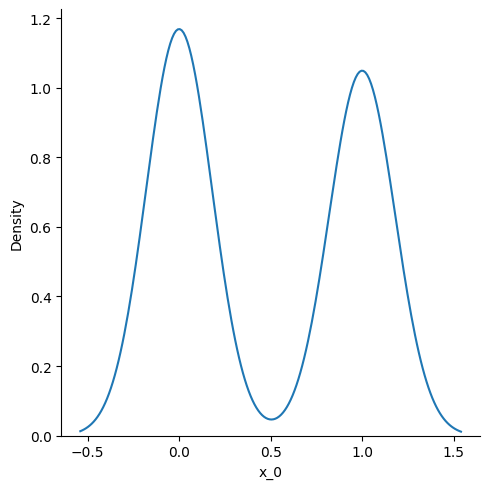

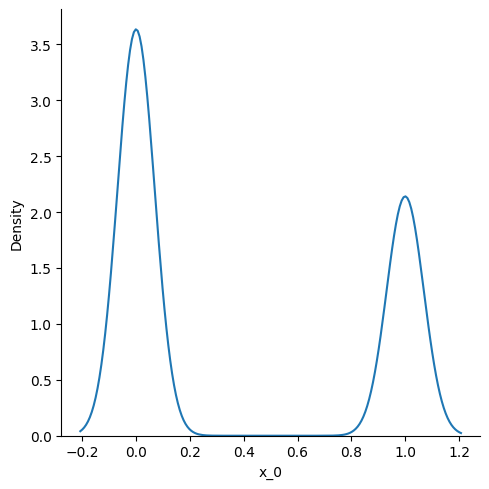

In [6]:
import seaborn as sns
sns.displot(data[['x_0']], x="x_0", kind="kde")
sns.displot(synthetic_data[['x_0']], x="x_0", kind="kde")

In [7]:
from sdv.evaluation.single_table import run_diagnostic

diagnostic_report = run_diagnostic(
    real_data=data.drop(columns=[f"y_{i}" for i in range(len(target.columns))]),
    synthetic_data=synthetic_data.drop(columns=[f"y_{i}" for i in range(len(target.columns))]),
    metadata=metadata)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 89/89 [00:00<00:00, 4238.07it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 500.81it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



In [8]:
from sdv.evaluation.single_table import evaluate_quality

metadata_drop_target = SingleTableMetadata()
metadata_drop_target.detect_from_dataframe(data.drop(columns=[f"y_{i}" for i in range(len(target.columns))]))

quality_report = evaluate_quality(
    real_data=data.drop(columns=[f"y_{i}" for i in range(len(target.columns))]).reset_index(drop=True),
    synthetic_data=synthetic_data.drop(columns=[f"y_{i}" for i in range(len(target.columns))]).reset_index(drop=True),
    metadata=metadata_drop_target)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 40/40 [00:00<00:00, 434.81it/s]|
Column Shapes Score: 49.27%

(2/2) Evaluating Column Pair Trends: |██████████| 780/780 [00:07<00:00, 98.47it/s]| 
Column Pair Trends Score: 91.4%

Overall Score (Average): 70.33%



In [12]:
X_unlabeled = synthetic_data.drop(columns=[f"y_{i}" for i in range(len(target.columns))]).to_numpy()
y_train = y_train
y_unlabeled = synthetic_data[[f"y_{i}" for i in range(len(target.columns))]].to_numpy()


initial_r2 = reg.score(X_test,y_test)



#improvement_threshold = 0.01  # 設定提升R²的閾值
selected_feature = np.empty((0, X_test.shape[1]))
selected_target = np.empty((0, y_test.shape[1]))
for i in range(len(X_unlabeled)):
    # 評估添加每個樣本後的R²變化
    candidate_feature = X_unlabeled[i].reshape(1, -1)
    candidate_target = y_unlabeled[i].reshape(1, -1)

    # 暫時增加樣本
    if selected_feature.size != 0 and selected_target.size != 0:
    #learner.teach(candidate_sample, candidate_label)
        X_new = np.vstack((X_test.to_numpy(), candidate_feature,selected_feature))
        y_new = np.vstack((y_test.to_numpy(), candidate_target,selected_target))
    else:
        X_new = np.vstack((X_test.to_numpy(), candidate_feature))
        y_new = np.vstack((y_test.to_numpy(), candidate_target))
    new_r2 = reg.score(X_new, y_new)
    # 檢查R²是否顯著提升
    if new_r2 > initial_r2:
        selected_feature = np.vstack((selected_feature, candidate_feature)) #np.append(selected_feature,candidate_feature).reshape(1, -1)
        selected_target  = np.vstack((selected_target, candidate_target)) #np.append(selected_target,candidate_target).reshape(1, -1)
        initial_r2 = new_r2  # 更新R²基準
        #print(initial_r2)
        
    # else:
    #     # #print("HHHHH",selected_samples)
    #     # # 如果沒有顯著提升，回退模型
    #     # learner = ActiveLearner(
    #     #     estimator=RandomForestRegressor(n_estimators=100),
    #     #     X_training=np.vstack((X_train.to_numpy(), X_unlabeled[selected_samples])),
    #     #     y_training=np.vstack((y_train.to_numpy(), y_unlabeled[selected_samples].reshape(-1,1)))
    #     # )

    # # 打印當前模型性能
    #print(f'Iteration {i+1}, New R²: {new_r2:.4f}')

# 打印選擇的樣本索引
#print("Selected samples that significantly improve R²:")
#print(selected_samples)

In [21]:
# 實驗 1
reg.score(X_test,y_test)
reg.score(selected_feature,selected_target)

0.7362574930917168

In [18]:
# 實驗 2
X_train_new = np.vstack((X_train.to_numpy(),selected_feature))#.shape
y_train_new = np.vstack((y_train.to_numpy(),selected_target))
reg2 = xgb.XGBRegressor(tree_method="hist", multi_strategy="multi_output_tree")
reg2.fit(X_train_new, y_train_new)
reg2.score(X_test,y_test)

0.5608452558517456

In [20]:
# 實驗3
X_new = np.vstack((feature.to_numpy(),selected_feature))#.shape
y_new = np.vstack((target.to_numpy(),selected_target))
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y_new, test_size=0.33, random_state=np.random.randint(0,1000))

reg3 = xgb.XGBRegressor(tree_method="hist", multi_strategy="multi_output_tree")

reg3.fit(X_train, y_train)
reg3.score(X_test,y_test)

0.7188575947523477

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    feature, target, test_size=0.33, random_state=np.random.randint(0,1000))

reg2 = xgb.XGBRegressor(tree_method="hist", multi_strategy="multi_output_tree")

reg2.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy='multi_output_tree', n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [24]:
reg2.score(X_test,y_test)

0.30246710777282715

In [23]:
reg2.score(selected_feature,selected_target)

0.38279886249101164

In [25]:
selected_feature.shape

(473, 40)

In [16]:
reg2.fit(X_train_new,y_train_new)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy='multi_output_tree', n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [17]:
reg2.score(X_test,y_test)

0.5121256709098816

In [33]:
selected_feature_df.columns = list(map(lambda x: "x_" +str(x) ,range(len(selected_feature_df.columns))))
selected_target_df.columns = list(map(lambda x: "y_" +str(x) ,range(len(selected_target_df.columns))))
selected_df = pd.concat([selected_feature_df,selected_target_df],axis=1)

quality_report = evaluate_quality(
    real_data=data.drop(columns=[f"y_{i}" for i in range(len(target.columns))]).reset_index(drop=True),
    synthetic_data=selected_df.drop(columns=[f"y_{i}" for i in range(len(target.columns))]).reset_index(drop=True),
    metadata=metadata_drop_target)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 40/40 [00:00<00:00, 909.12it/s]|
Column Shapes Score: 41.25%

(2/2) Evaluating Column Pair Trends: |██████████| 780/780 [00:05<00:00, 142.71it/s]|
Column Pair Trends Score: 66.93%

Overall Score (Average): 54.09%



In [29]:
selected_feature_df = pd.DataFrame(selected_feature)
selected_target_df = pd.DataFrame(selected_target)